In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from tensorflow.python.keras.losses import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("data_for_model.csv")
df.shape

(4018, 23)

In [3]:
df.head()

,Unnamed: 0,Station1_CO,Station1_NO2,Station1_NOx,Station1_PM10,Station1_SO2,Station2_CO,Station2_NO2,Station2_NOx,Station2_O3,...,humidity,precip,precipcover,cloudcover,windspeed,visibility,is_heating_season,is_work_day,winddir_sin,winddir_cos
0,2014-01-01,1057.0,31.3,67.6,56.0,6.96,1121.0,19.9,27.5,9.3,...,91.5,0.000,0.00,58.3,7.3,2.6,1,1,0.979223,-0.202787
1,2014-01-02,1030.0,37.0,89.1,60.0,11.12,1212.0,25.9,44.4,9.9,...,83.0,0.000,0.00,60.4,10.9,6.4,1,1,0.685818,-0.727773
2,2014-01-03,1319.0,49.1,196.1,69.0,10.18,1292.0,26.3,60.5,7.5,...,82.9,0.000,0.00,61.5,14.3,11.0,1,1,0.068015,-0.997684
3,2014-01-04,1001.0,36.9,94.8,46.0,11.66,952.0,21.6,27.3,7.6,...,88.5,0.398,4.17,83.2,17.9,8.0,1,0,0.432086,-0.901833
4,2014-01-05,1155.0,37.3,102.6,39.0,9.32,1001.0,23.4,36.6,12.5,...,79.0,0.300,12.50,92.1,21.4,18.0,1,0,0.436802,-0.899558


In [4]:
df["Date"] = df["Unnamed: 0"]
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.set_index("Date", inplace=True)

In [6]:
df.isna().sum()

,0
Station1_CO,0
Station1_NO2,0
Station1_NOx,0
Station1_PM10,0
Station1_SO2,0
Station2_CO,0
Station2_NO2,0
Station2_NOx,0
Station2_O3,158
Station2_PM10,0


In [7]:
features = [
    "Station1_CO", "Station1_NO2", "Station1_NOx",
    "Station2_CO", "Station2_NO2", "Station2_NOx", "Station2_O3",
    "Station1_PM10", "temp", "humidity", "precip",
    "precipcover", "cloudcover", "windspeed", "visibility",
    "winddir_sin", "winddir_cos", "is_heating_season", "is_work_day"
]
target = "Station2_PM10"

In [8]:
print(df.isnull().sum())
df.fillna(method="ffill", inplace=True)

Station1_CO            0
Station1_NO2           0
Station1_NOx           0
Station1_PM10          0
Station1_SO2           0
Station2_CO            0
Station2_NO2           0
Station2_NOx           0
Station2_O3          158
Station2_PM10          0
Station2_SO2           0
temp                   0
humidity               0
precip                 0
precipcover            0
cloudcover             0
windspeed              0
visibility             0
is_heating_season      0
is_work_day            0
winddir_sin            0
winddir_cos            0
dtype: int64


<ipython-input-8-d837759882ff>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [9]:
print(df.isnull().sum())

Station1_CO          0
Station1_NO2         0
Station1_NOx         0
Station1_PM10        0
Station1_SO2         0
Station2_CO          0
Station2_NO2         0
Station2_NOx         0
Station2_O3          0
Station2_PM10        0
Station2_SO2         0
temp                 0
humidity             0
precip               0
precipcover          0
cloudcover           0
windspeed            0
visibility           0
is_heating_season    0
is_work_day          0
winddir_sin          0
winddir_cos          0
dtype: int64


In [10]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
df_features_scaled = scaler_features.fit_transform(df[features])
df_target_scaled = scaler_target.fit_transform(df[[target]])
df_scaled = np.hstack((df_features_scaled, df_target_scaled))

In [11]:
def create_sequences(data, target_index, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

In [12]:
SEQ_LENGTH = 24

X, y = create_sequences(df_scaled, target_index=len(features), seq_length=SEQ_LENGTH)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [13]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2]))),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.1994 - mae: 0.1994 - val_loss: 0.0412 - val_mae: 0.0412 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0881 - mae: 0.0881 - val_loss: 0.0438 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0399 - val_mae: 0.0399 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0596 - mae: 0.0596 - val_loss: 0.0363 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0553 - mae: 0.0553 - val_loss: 0.0451 - val_mae: 0.0451 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0548 - mae: 0.0548 - val_loss: 0.0494 - val_mae: 0.0494 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0502 - mae: 0.0502 - val_loss: 0.0398 - val_mae: 0.0398 - learning_rate

In [17]:
y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [18]:
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler_target.inverse_transform(y_pred).flatten()

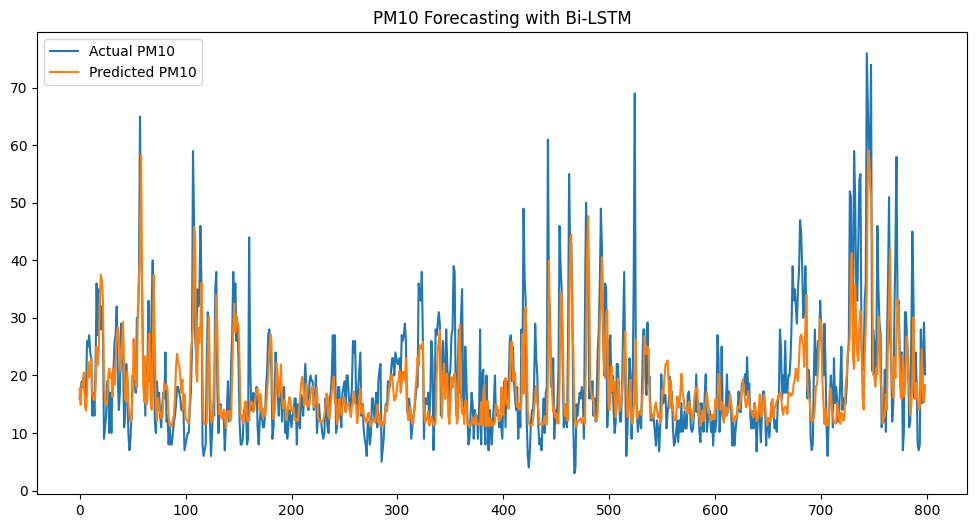

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual PM10')
plt.plot(y_pred_actual, label='Predicted PM10')
plt.legend()
plt.title('PM10 Forecasting with Bi-LSTM')
plt.show()

In [20]:
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"MAE: {mae}")
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f"MSE: {mse}")
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R2: {r2}")

MAE: 5.322874069213867
MSE: 61.96684265136719
R2: 0.4437632451027115
